<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.patches as mpathes
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import random
import math

In [2]:
SIZE = 40       #基本尺寸
#元胞自动机迭代次数
TIMES = 5 #元胞自动机迭代次数

#斜坡属性
WIDTH = 20       #斜坡宽度
HEIGHT = 40      #斜坡高度
K = WIDTH/HEIGHT  #斜坡斜率

#海浪属性
WIDE_HEIGHT = 8   #海浪高度
WIDE_STRENGTH = 2  #海浪强度


#沙子属性
sand_r = 0.002 #沙子半径2mm
sand_p = 2.65*1000 #沙子的密度
sand_n0 = 10 #粘性系数
snad_v0 = 0.2 #泊松比
sand_m0 = 0.4 #摩擦系数
water_v = 6 #离开速度


H_0 = 1.0 #波高  --夏天1.3  冬天0.7
h_0 = 5 #海洋深度
g = 9.7863 #重力加速度 —— 按照海口来的
c_0 = math.sqrt(g*(h_0+H_0)) #波速

distance_10 = 3000 #3.0km --- 10m
distance_5 = 860 # 800m --- 5m
ocean_k = h_0/distance_5 

beach_width = 60 #单位m
beach_height = 2.4 #单位m
#beach_angle = 5*math.pi/180
beach_k = beach_height/beach_width

In [3]:
#对数正态分布
def p_fun(x):
    #可调参数
    p_u=0.3
    p_a=0.6
    a=1/(math.sqrt(2*np.pi)*p_a*x)
    c=-0.5*math.pow(math.log(x)-p_u,2)/math.pow(p_a,2)
    b=np.exp(c)
    res = a*b
    return res
#抵抗力
def F_fun(x,n):
    cell_d = sand_r*2*5 #每个元胞有5x5x5的沙子组成
    cell_mass = math.pow(cell_d,3)*sand_p #元胞质量
    
    sand_m = sand_m0 * np.exp(-x)
    sand_n = sand_n0 * p_fun(x)
    F_f=sand_m*cell_mass*g*n
    F_a=np.pi*6*sand_n*sand_r
    F_s=snad_v0/(1+snad_v0)/2*cell_mass*g*n
    F = F_f + F_a - F_s
    return F,F_f,F_a

#含水量与下降概率
def P_water(x):
    if x == 0:
        return 0.57
    else:
        a,b,c=F_fun(x,1)
        return (0.35-a)*2

In [4]:
#初始化
def initial():
    #设置每一个切片的斜率
    K_initial= [K for i in range(SIZE)]
    #定义三维空间沙粒的有无
    image = np.zeros((SIZE, SIZE, SIZE))
    hum = np.zeros((SIZE, SIZE, SIZE))
    for h in range(SIZE):
        K_xz = K_initial[h]
        for i in range(SIZE):
            if i < HEIGHT :
                for j in range(SIZE):
                    hum[h,i,j]=1
                    if j < i*K_xz:
                        image[h,i,j] = 0
                    else:
                        image[h,i,j] = 1
            else:
                for j in range(SIZE):
                    image[h,i,j] = 0
    return image,hum


In [16]:
#计算三维空间中的高度 ，计算三维空间中的hj平面/xy平面投影
def cliff_height(image):
    height=np.zeros((SIZE, SIZE))
    for h in range(SIZE):
        for j in range(SIZE):
            term = 0 
            for i in range(SIZE):
                if image[h,i,j] == 1 :
                    term = i+1
            height[h,j]=term
    return height

#计算三维空间中的ij平面/xz平面投影
def cliff_xz(iamge):
    height=np.zeros((SIZE, SIZE))
    for i in range(SIZE):
        for j in range(SIZE):
            term = 0 
            for h in range(SIZE):
                if image[h,i,j] == 1 :
                    term = i+1
            height[i,j]=term
    return height

#计算三维空间中的ih平面/yz平面投影
def cliff_yz(iamge):
    height=np.zeros((SIZE, SIZE))
    for i in range(SIZE):
        for h in range(SIZE):
            term = 0 
            for j in range(SIZE):
                if image[h,i,j] == 1 :
                    term = i+1
            height[i,h]=term
    return height

#根据高度还原三维坐标
def len2pos(cliff_len):
    image = np.zeros((SIZE, SIZE, SIZE))
    for h in range(SIZE):
        for j in range(SIZE):
            for i in range(SIZE):
                if cliff_len[h,j] > i:
                    image[h,i,j] = 1
                else:
                    image[h,i,j] = 0
    return image

#计算多个方向上的差值函数
def cliff_difference(height):
    cliff_dif=np.zeros((SIZE, SIZE,4))
    #cliff_dif为三维数组
    #cliff_dif[h,j,0] -j 方向
    #cliff_dif[h,j,1] +j 方向
    #cliff_dif[h,j,2] -h 方向
    #cliff_dif[h,j,3] +h 方向
    for h in range(SIZE):
        for i in range(SIZE):
            if i == 0 :
                cliff_dif[h,i,0] = height[h,i]
                cliff_dif[h,i,1] = height[h,i] - height[h,i+1]
            elif i == SIZE - 1 :
                cliff_dif[h,i,0] = height[h,i] - height[h,i-1]
                cliff_dif[h,i,1] = height[h,i]              
            else:
                cliff_dif[h,i,0] = height[h,i] - height[h,i-1]
                cliff_dif[h,i,1] = height[h,i] - height[h,i+1]
    for i in range(SIZE):
        for h in range(SIZE):
            if h == 0 :
                cliff_dif[h,i,2] = height[h,i]
                cliff_dif[h,i,3] = height[h,i] - height[h+1,i]
            elif h == SIZE - 1 :
                cliff_dif[h,i,2] = height[h,i] - height[h-1,i]
                cliff_dif[h,i,3] = height[h,i]              
            else:
                cliff_dif[h,i,2] = height[h,i] - height[h-1,i]
                cliff_dif[h,i,3] = height[h,i] - height[h+1,i]
    return cliff_dif

In [6]:
def wave_fun(x,t):
    T=10
    H=0.6
    c=1
    fall=40
    w=(x+c*t)/(T*c)*2*np.pi
    
    pos = H/2*np.sin(w)*np.exp(-x/fall)+H/2
    v_level = c*np.cos(w)*np.exp(-x/fall)
    v_vertical = c*np.sin(w)*np.exp(-x/fall)
    return pos,v_level,v_vertical

def tide_fun(x):
    a0 = 124.8
    a1 = 64.05
    b1 = 14.88 
    a2 = -0.5196 
    b2 =  27.36 
    w  =  0.2559  
    result = a0 + a1*math.cos(x*w) + b1*math.sin(x*w) + a2*math.cos(2*x*w) + b2*math.sin(2*x*w)
    return result/600

def wave_tide_fun(T,x,t):
    tide = tide_fun(T)
    wave,v_level,v_vertical = wave_fun(x,t)
    w_t = tide + wave
    return w_t,v_level,v_vertical

def v_level2depth(v):
    a,b,c=wave_tide_fun(11,40,0)
    v_max = b
    a,b,c=wave_tide_fun(11,42,0)
    v_min = b
    v_ave = v_max - v_min
    v_d1 = v_ave/2
    v_d2 = v_ave/2
    n_d1 = math.floor((v-v_min)/v_d1)+1
    n_d2 = math.floor((v-v_min)/v_d2)+1
    return int(n_d1),int(n_d2)

In [7]:
d_near = 40 
cell_d = 2/40
#海浪冲击函数
#假设对于每一层沙子是同时作用的，即，同时抽空
def wave_function(image,hum,T=11,t=0):
    for h in range(SIZE):
        for i in range(SIZE):
            if i < WIDE_HEIGHT:
                term = 0
                for j in range(SIZE):
                    if image[h,i,j] == 1:
                        term = j
                        break
                x = d_near + term*cell_d
                #评估边缘列的影响
                w_t,v_l,v_v=wave_tide_fun(T,x,t)
                #根据海浪的结果，得到
                if i*cell_d <= w_t :
                    depth,num = v_level2depth(v_l)
                    for k in range(depth):
                        if term + k < SIZE-1 :
                            hum[h,i,term+k+num] =  hum[h,i,term+k] + 0.25 #增加湿度
                    for k in range(num):
                        if term + k < SIZE -1 :
                            image[h,i,term+k] = 0 #冲刷带走                    
    return image,hum

In [8]:
#定义沙堆下坠规则
#比较向四个方向下坠的概率，向概率大的方向下坠
#现在，只考虑沿着 -j 和 -h 两个矢量方向的影响
#即只考虑 cliff_dif[h,j][0] 和 cliff_dif[h,j][2]两个量p1,p2
#首先评估 p1 ， p2 选择概率大的方向下坠

#下坠函数
def fall_function(cliff_len,image,hum):
    for times in range(TIMES): #计算10次
        cliff_dif = cliff_difference(cliff_len)
        for h in range(SIZE):
            for j in range(SIZE):
                #p1,p2=0,0
                p_1 = [0,0,0,0]
                p_2 = [0,0,0,0]
                p=[0,0,0,0]
                for k in [0,1,2,3]:
                    if( cliff_dif[h,j,k] >=2 ):
                        p_1[k] =  0.5+(cliff_dif[h,j,k]-2)*0.25
                i=[ cliff_len[h,j]-cliff_dif[h,j,0],cliff_len[h,j]-cliff_dif[h,j,1],cliff_len[h,j]-cliff_dif[h,j,2],cliff_len[h,j]-cliff_dif[h,j,3]  ]
                num = [0,0,0,0]
                sum_hum = [0,0,0,0]
                ave_hum = [0,0,0,0]
                for k in [0,1,2,3]:
                    position=[(h,int(i[k]),j),(h-1,int(i[k]),j+1),(h+1,int(i[k]),j),
                              (h,int(i[k]),j-1),(h,int(i[k]),j+1),(h,int(i[k])-1,j),(h,int(i[k])+1,j)]
                    for pos in position:
                        if ( (pos[0]<SIZE) & (pos[1]<SIZE) & (pos[2]<SIZE) &  (pos[0]>=0) & (pos[1]>=0) & (pos[2]>=0) ):
                            #print(pos)
                            #print(image[pos])
                            if( image[pos] == 1) :
                                num[k] = num[k] + 1
                                sum_hum[k] = sum_hum[k] + hum[pos]
                    if num[k]>0:
                        ave_hum[k]=sum_hum[k]/num[k]
                    else :
                        ave_hum[k]=0
                    p_2[k] = P_water(ave_hum[k])
                for k in [0,1,2,3]:
                    p[k]=p_1[k]+p_2[k]
                direction = p.index(max(p))
                if p[direction] > random.randint(0,100)/100 :
                    if direction == 0:
                        if (j-1) >=0 :
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,0]/2)#该位置减小差值的一半并向上取整
                            cliff_len[h,j-1] = cliff_len[h,j-1] + (cliff_dif[h,j,0] - math.ceil(cliff_dif[h,j,0]/2))  
                        else:
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,0]/2)#该位置减小差值的一半并向上取整
                    elif direction == 1:
                        if (j+1) < SIZE :
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,0]/2)#该位置减小差值的一半并向上取整
                            cliff_len[h,j+1] = cliff_len[h,j+1] + (cliff_dif[h,j,0] - math.ceil(cliff_dif[h,j,0]/2))  
                        else:
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,0]/2)#该位置减小差值的一半并向上取整
                    elif direction == 2:
                        if (h-1) >= 0 :
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,2]/2)#该位置减小差值的一半并向上取整
                            cliff_len[h-1,j] = cliff_len[h-1,j] + (cliff_dif[h,j,2] - math.ceil(cliff_dif[h,j,2]/2))  
                        else:
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,0]/2)#该位置减小差值的一半并向上取整
                    elif direction == 3:
                        if (h+1) <SIZE :
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,2]/2)#该位置减小差值的一半并向上取整
                            cliff_len[h+1,j] = cliff_len[h+1,j] + (cliff_dif[h,j,2] - math.ceil(cliff_dif[h,j,2]/2))   
                        else:
                            cliff_len[h,j] = cliff_len[h,j] - math.ceil(cliff_dif[h,j,0]/2)#该位置减小差值的一半并向上取整
    return cliff_len

In [9]:
#雨水的作用模型
def rain_function(hum,cliff_len):
    for h in range(SIZE):
        for j in range(SIZE):
            if cliff_len[h,j] > 0 :
                i = cliff_len[h,j]-1
                if i > 0:
                    hum[h,i,j]=hum[h,i,j]+0.1
    return hum

In [10]:
def draw(image,name):
    _x = np.arange(SIZE)
    _y = np.arange(SIZE)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    height=cliff_height(image)
    top = height.ravel()

    x_o=[]
    y_o=[]
    bottom_o=[]
    top_o=[]
    for h in range(SIZE):
        for j in range(SIZE):
            if image[h,0,j] == 0 :
                x_o.append(j)
                y_o.append(h)
                bottom_o.append(0)
                top_o.append(0.8)


    # setup the figure and axes
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')

    bottom = np.zeros_like(top)
    width = depth = 1

    ax1.bar3d(x, y, bottom, width, depth, top, shade=True,color='#F4A460')
    #如果非初始状态，把注释去掉，加上水的影响
    #ax1.bar3d(x_o, y_o,bottom_o , width, depth, top_o, shade=False,color='#20B2AA6E')
    #ax1.set_title('Shaded')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_zlim(0, SIZE)
    ax1.set_xlim(0, SIZE)
    ax1.set_ylim(0, SIZE)
    ax1.view_init(elev=10., azim=-135) 
    plt.savefig(name)
    plt.show()

In [11]:
#建立对于模型的评价体系

#-------评价1--------
#材料损失率
def num_calculate(image):
    num = 0
    for h in range(len(image)):
        for i in range(len(image)):
            for j in range(len(image)):
                if image[h,i,j]==1:
                    num = num + 1
    return num

#--------评价2--------
#最大高度
def highest_calculate(height):
    highest = 0
    for i in range(SIZE):
        for j in range(SIZE):
            if height[i,j] > highest:
                highest = height[i,j]
    return highest

In [12]:
#-------评价3--------
#投影图
def reflect_calculate(image,name):
    height_xy = cliff_height(image)
    height_xz = cliff_xz(image)
    height_yz = cliff_yz(image)

    fig, ax = plt.subplots(1,3,figsize=(18,6))#figsize=(6,6)
    im = ax[0].imshow(height_xy)
    ax[0].set_title("xy")
    ax[0].invert_yaxis() 
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[1].imshow(height_xz)
    ax[1].set_title("xz")
    ax[1].invert_yaxis() 
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[2].imshow(height_yz)
    ax[2].set_title("yz")
    ax[2].invert_yaxis() 
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.suptitle('The projection drawings ')
    fig.tight_layout()
    plt.savefig(name)
    plt.show()

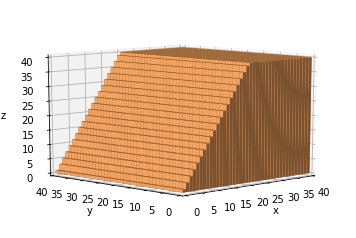

In [13]:
image,hum=initial()
num_0 = num_calculate(image)
draw(image,'001.png')

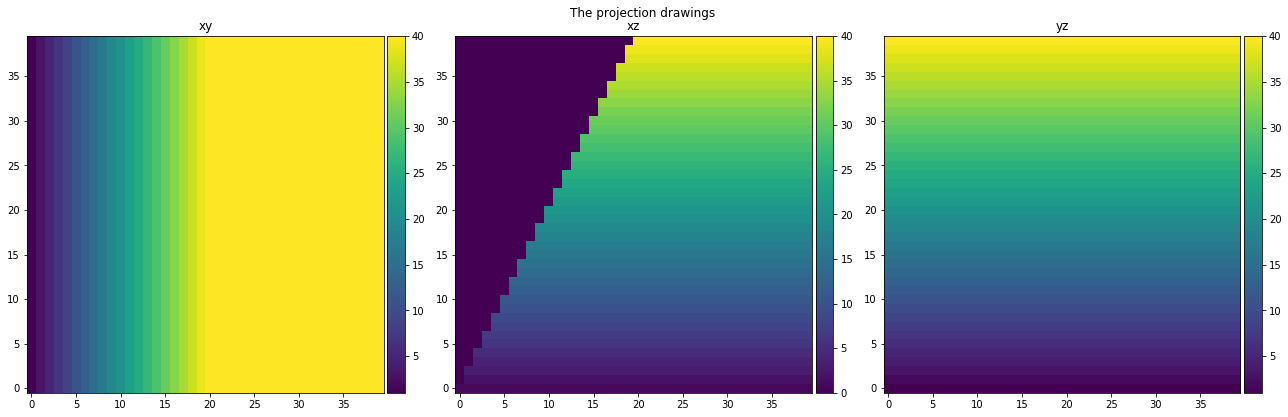

In [14]:
reflect_calculate(image,'002.png')

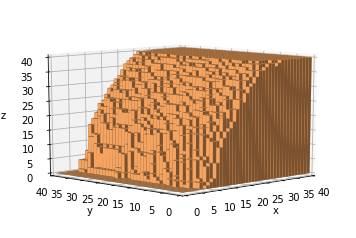

In [15]:
image,hum=initial()
#元胞自动机迭代次数
TIMES = 2
#定义海浪冲刷的次数
WAVE_TIMES = 5
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
num_1 = num_calculate(image)
draw(image,'003.png')

In [304]:
image,hum=initial()
#元胞自动机迭代次数
TIMES = 2
#定义海浪冲刷的次数
WAVE_TIMES = 5
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    rain_function(hum,cliff_len)
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
num_1 = num_calculate(image)
draw(image,'100.png')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

50840
46146
0.9076711250983478


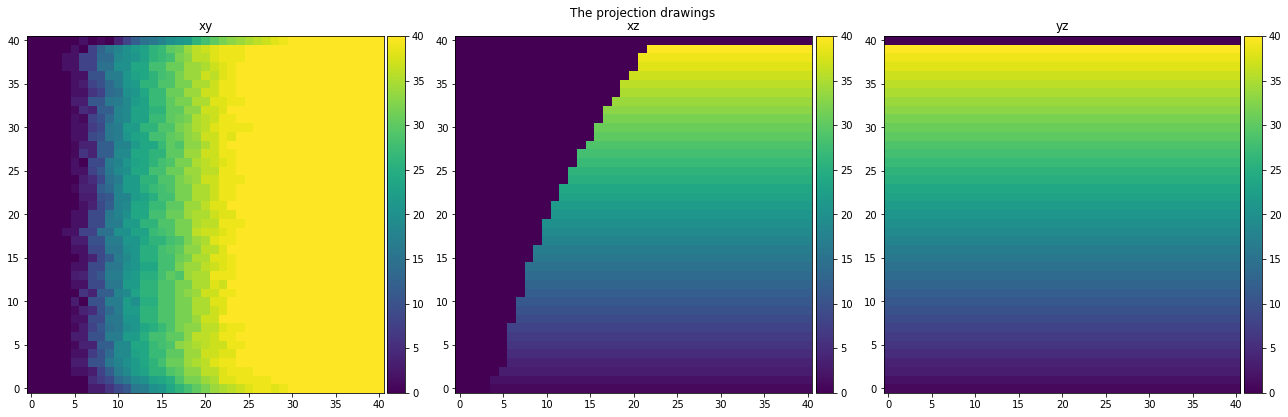

In [169]:
print(num_0)
print(num_1)
print(num_1/num_0)
reflect_calculate(image,'004.png')

In [89]:
#初始化——————注意修改SIZE大小
def initial_fromdata(name):
    #读取三维信息
    data = pd.read_excel(name,header=None)
    #定义三维空间沙粒的有无
    image = np.zeros((SIZE, SIZE, SIZE))
    hum = np.zeros((SIZE, SIZE, SIZE))
    for h in range(SIZE):
        for i in range(SIZE):
            for j in range(SIZE):
                hum[h,i,j]=1
                if i < data.iloc[h,j]:
                    image[h,i,j]=1
                else:
                    image[h,i,j]=0
    return image,hum

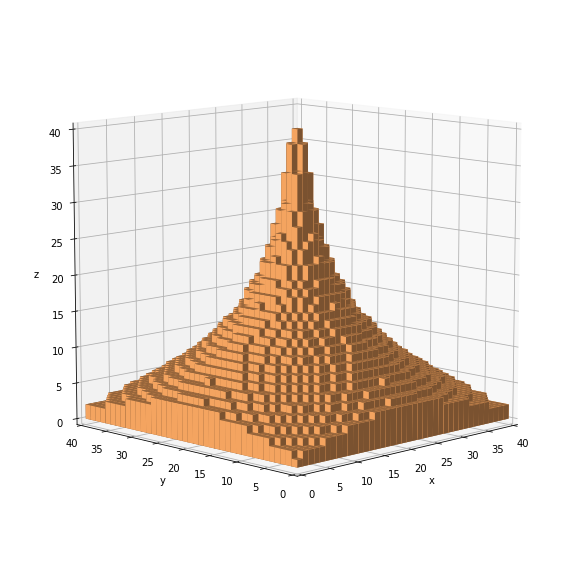

In [285]:
SIZE = 40
image,hum=initial_fromdata('最优曲线-40-40-15000.xlsx')
num_0 = num_calculate(image)
draw(image,'011.png')

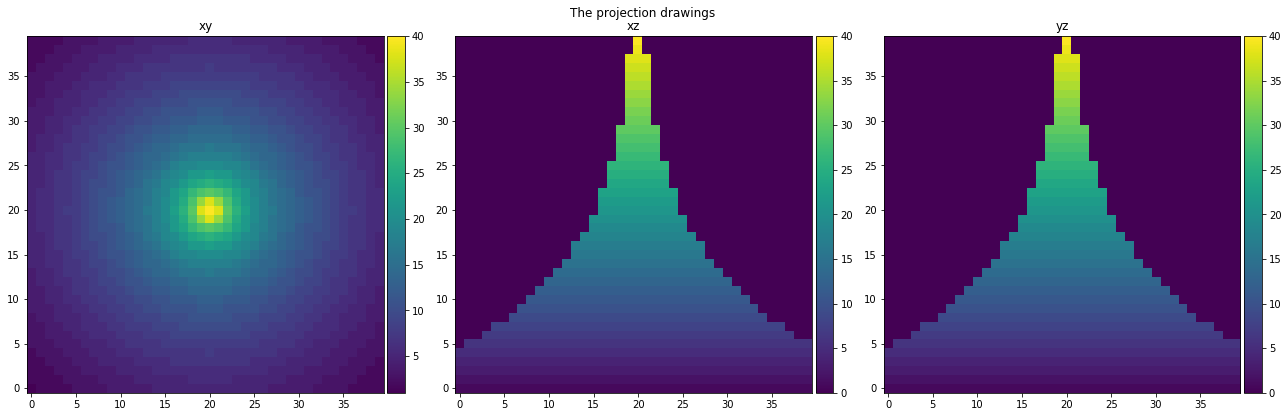

In [286]:
reflect_calculate(image,'012.png')

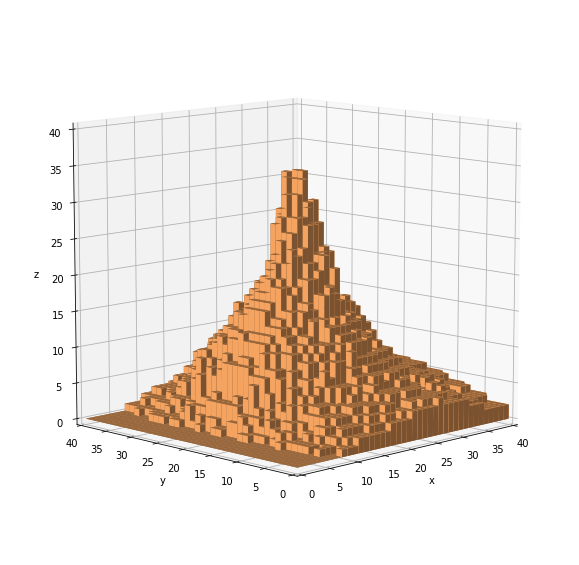

In [287]:
SIZE = 40
image,hum=initial_fromdata('最优曲线-40-40-15000.xlsx')
#元胞自动机迭代次数
TIMES = 2
#定义海浪冲刷的次数
WAVE_TIMES = 3
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
num_1 = num_calculate(image)
draw(image,'013.png')

14519
10532
0.7253943109029547


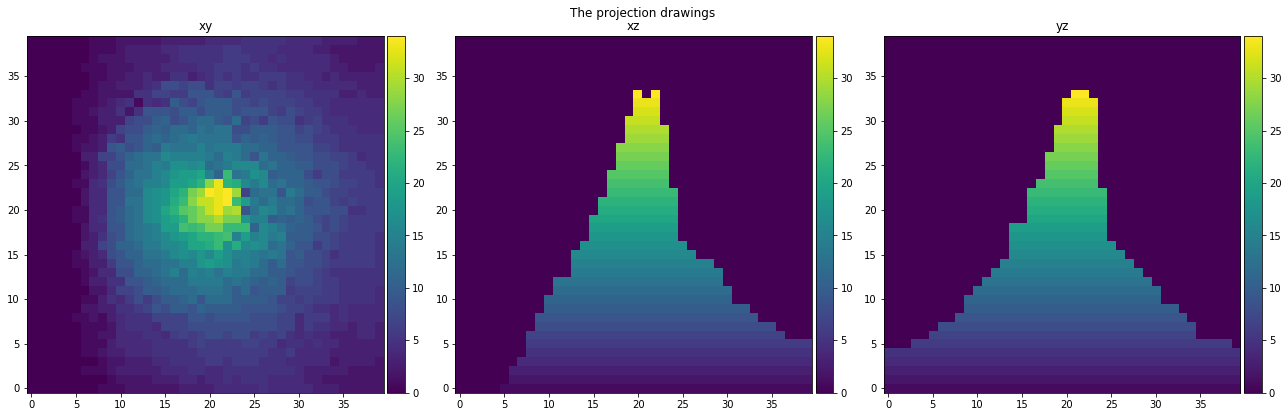

In [288]:
print(num_0)
print(num_1)
print(num_1/num_0)
reflect_calculate(image,'014.png')

In [299]:
SIZE = 40
image,hum=initial_fromdata('最优曲线-40-40-15000.xlsx')
#元胞自动机迭代次数
TIMES = 2
#定义海浪冲刷的次数
WAVE_TIMES = 30
num = []
highest = []
num.append(num_calculate(image))
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    highest.append(highest_calculate(cliff_len))
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
    num.append(num_calculate(image))

cliff_len=cliff_height(image)
highest.append(highest_calculate(cliff_len))
num_1 = num_calculate(image)
file_save(num,highest,'fake最优3曲线.txt')
#draw(image,'013.png')

In [298]:
SIZE = 40
image,hum=initial_fromdata('矩形—40-40,-16000.xlsx')
#元胞自动机迭代次数
TIMES = 5
#定义海浪冲刷的次数
WAVE_TIMES = 30
num = []
highest = []
num.append(num_calculate(image))
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    highest.append(highest_calculate(cliff_len))
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
    num.append(num_calculate(image))

cliff_len=cliff_height(image)
highest.append(highest_calculate(cliff_len))
num_1 = num_calculate(image)
file_save(num,highest,'fake矩形2曲线.txt')
#draw(image,'013.png')

In [247]:
def file_save(num,highest,name):
    file=open(name,'w')  
    file.write(str(num))
    file.write('\n')
    file.write(str(highest)) 
    file.close()

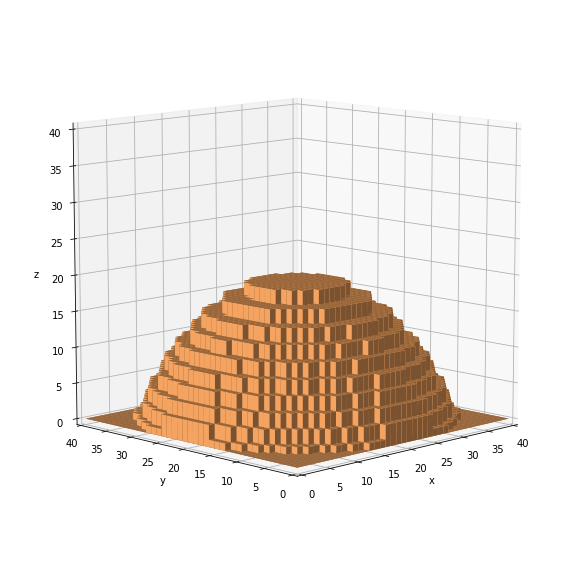

In [280]:
SIZE = 40
image,hum=initial_fromdata('凸曲线-40-40-15000.xlsx')
num_0 = num_calculate(image)
draw(image,'021.png')

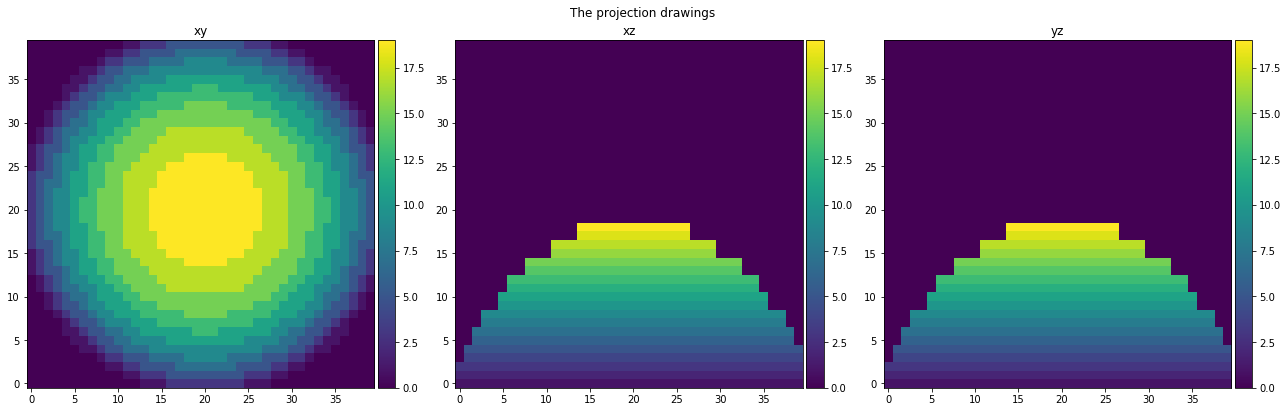

In [281]:
reflect_calculate(image,'022.png')

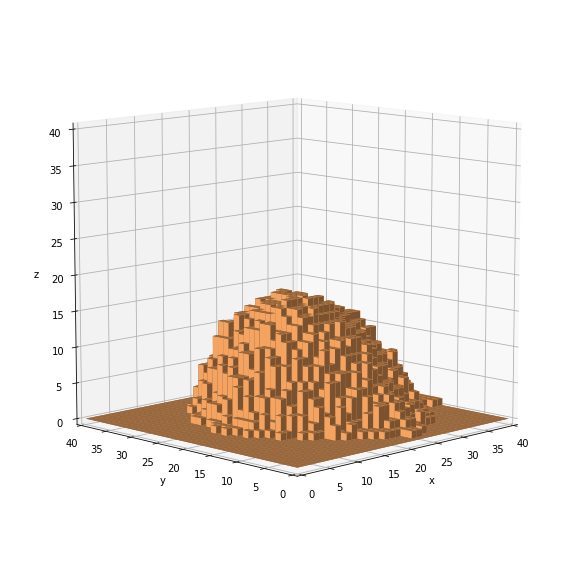

In [282]:
SIZE = 40
image,hum=initial_fromdata('凸曲线-40-40-15000.xlsx')
#元胞自动机迭代次数
TIMES = 5
#定义海浪冲刷的次数
WAVE_TIMES = 5
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
num_1 = num_calculate(image)
draw(image,'023.png')

14981
6262
0.41799612842934386


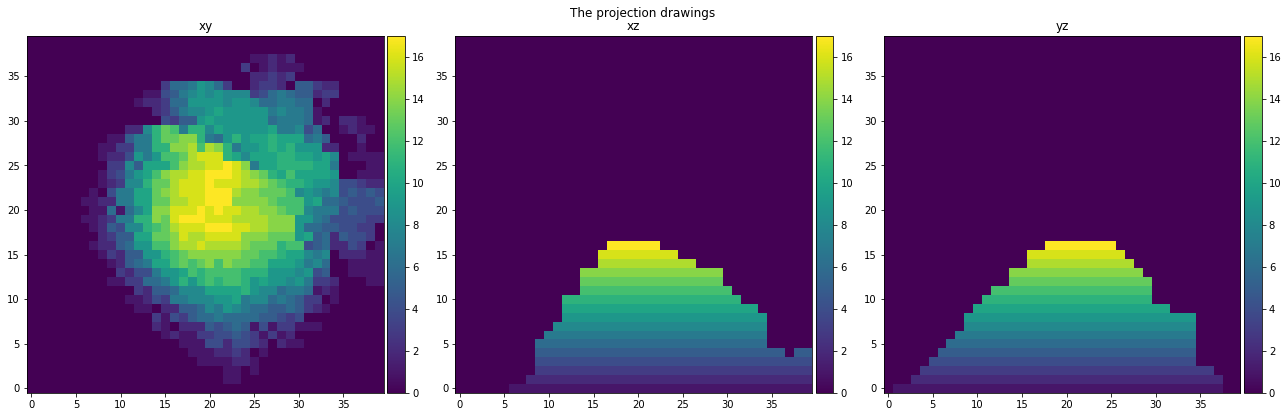

In [283]:
print(num_0)
print(num_1)
print(num_1/num_0)
reflect_calculate(image,'024.png')

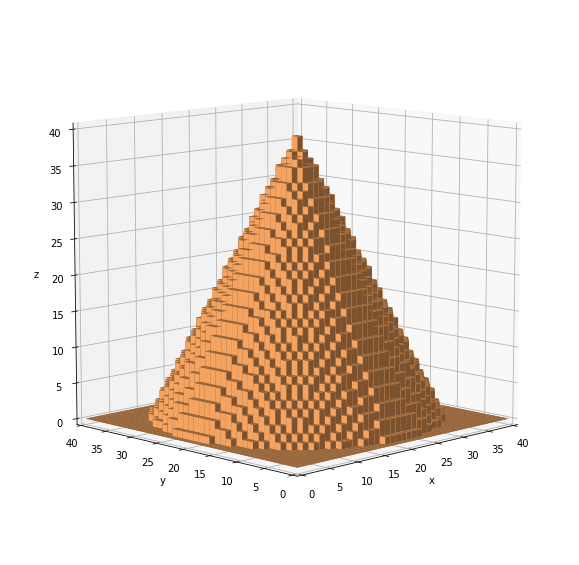

In [211]:
SIZE = 40
image,hum=initial_fromdata('圆锥曲线-40-40-15000.xlsx')
num_0 = num_calculate(image)
draw(image,'031.png')

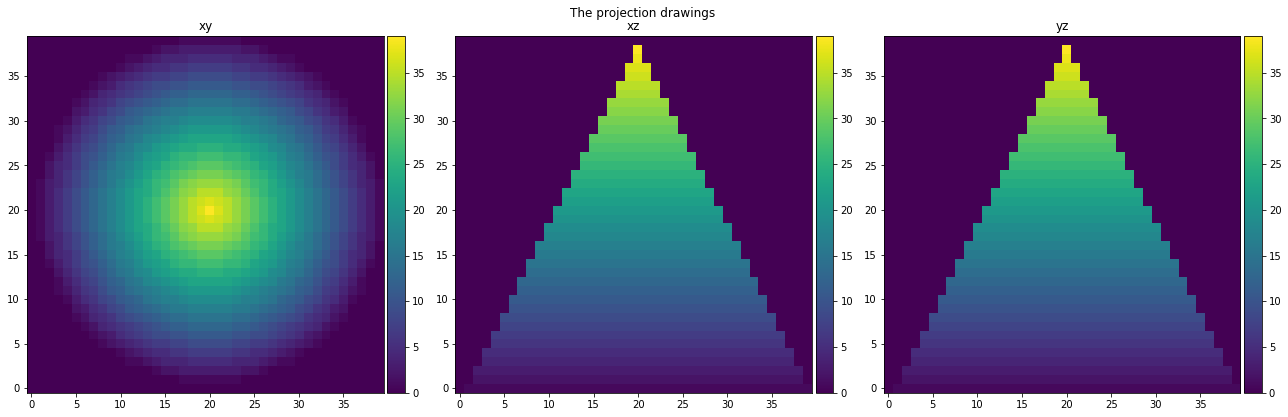

In [212]:
reflect_calculate(image,'032.png')

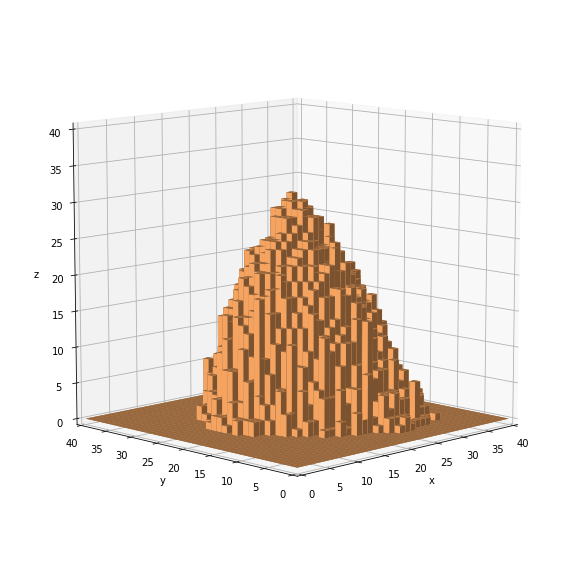

In [268]:
SIZE = 40
image,hum=initial_fromdata('圆锥曲线-40-40-15000.xlsx')
#元胞自动机迭代次数
TIMES = 2
#定义海浪冲刷的次数
WAVE_TIMES = 8
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
num_1 = num_calculate(image)
draw(image,'033.png')

14856
8224
0.5535810446957459


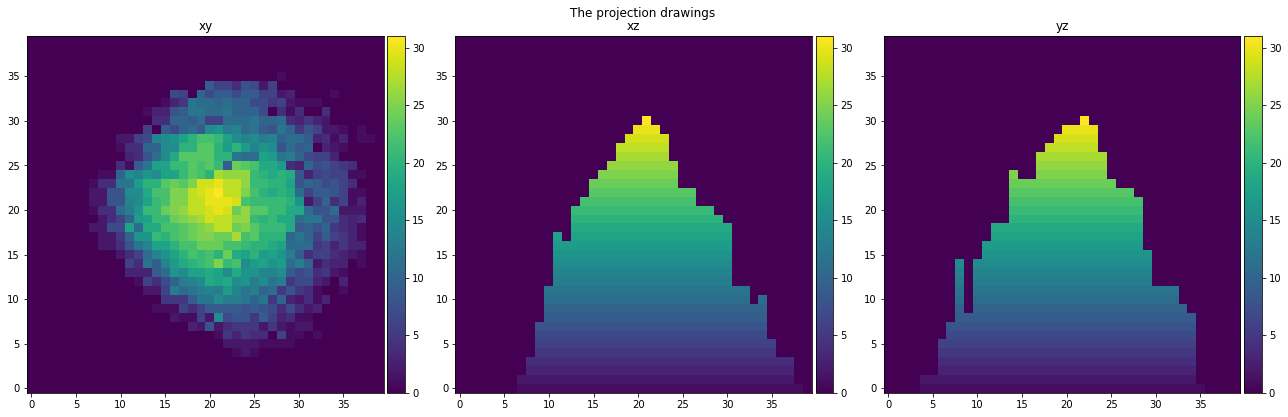

In [269]:
print(num_0)
print(num_1)
print(num_1/num_0)
reflect_calculate(image,'034.png')

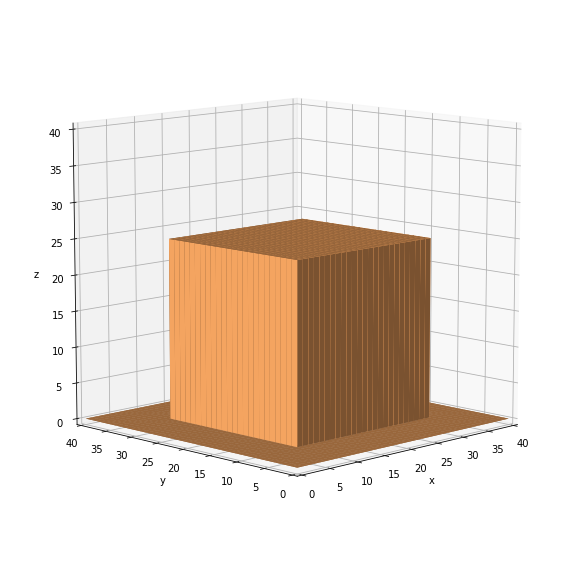

In [270]:
SIZE = 40
image,hum=initial_fromdata('矩形—40-40,-16000.xlsx')
num_0 = num_calculate(image)

draw(image,'041.png')

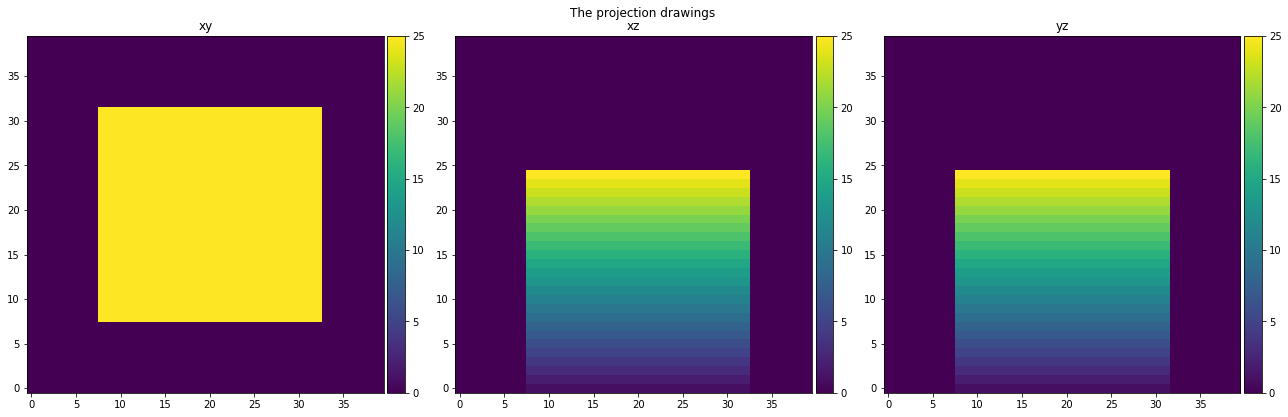

In [271]:
reflect_calculate(image,'042.png')

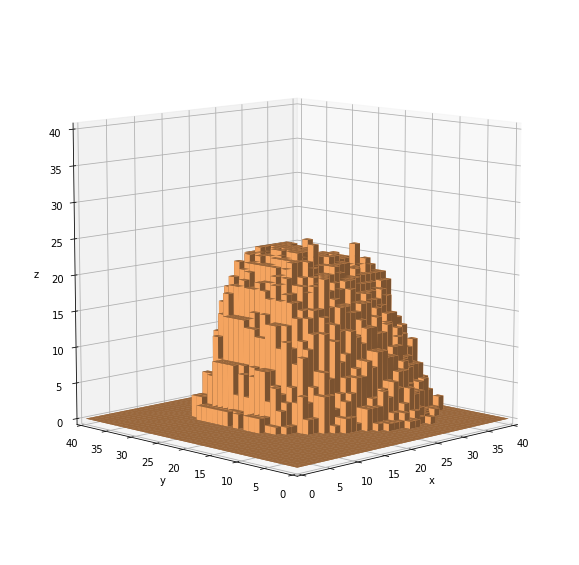

In [274]:
SIZE = 40
image,hum=initial_fromdata('矩形—40-40,-16000.xlsx')
#元胞自动机迭代次数
TIMES = 2
#定义海浪冲刷的次数
WAVE_TIMES = 15
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
num_1 = num_calculate(image)
draw(image,'043.png')

15000
8182
0.5454666666666667


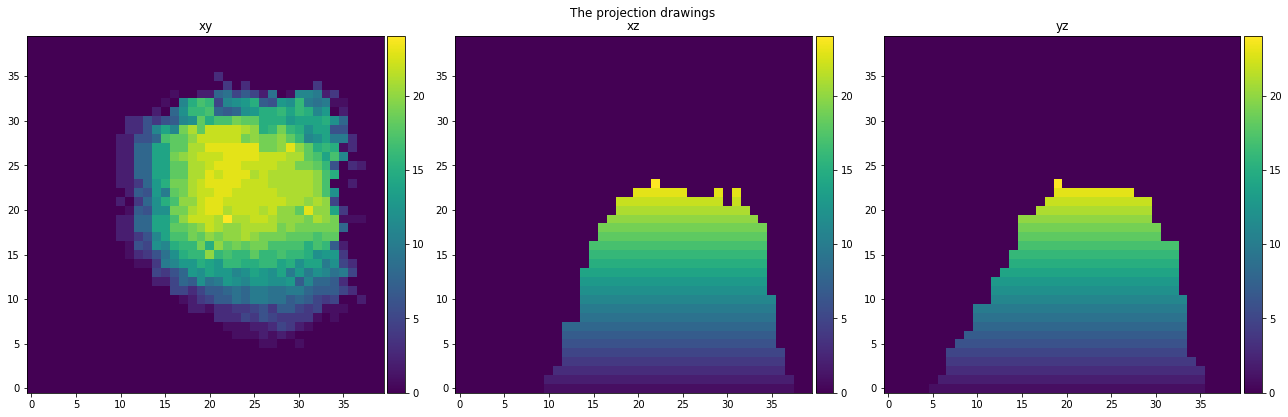

In [275]:
print(num_0)
print(num_1)
print(num_1/num_0)
reflect_calculate(image,'044.png')

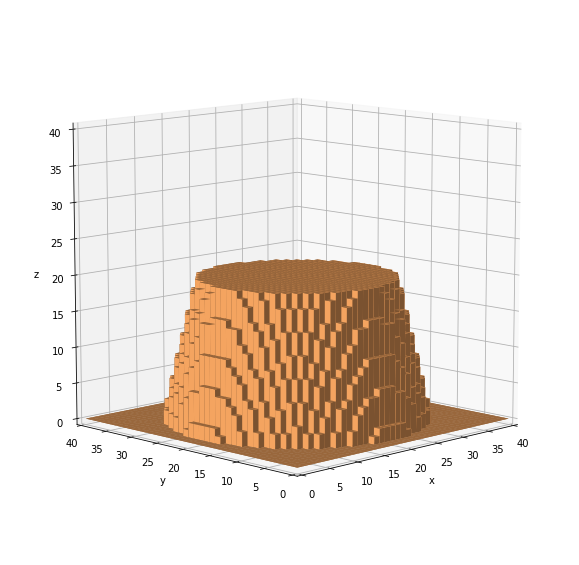

In [276]:
SIZE = 40
image,hum=initial_fromdata('圆台-40-40-15000.xlsx')
num_0 = num_calculate(image)

draw(image,'051.png')

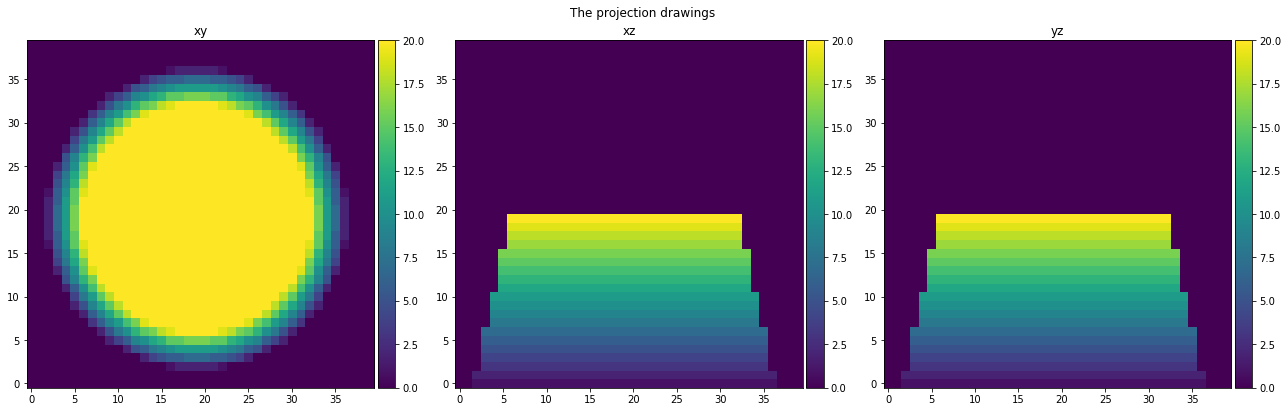

In [277]:
reflect_calculate(image,'052.png')

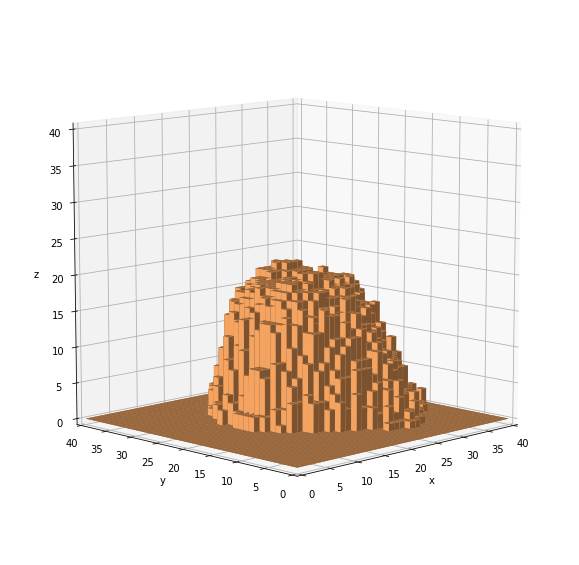

In [278]:
SIZE = 40
image,hum=initial_fromdata('圆台-40-40-15000.xlsx')
#元胞自动机迭代次数
TIMES = 2
#定义海浪冲刷的次数
WAVE_TIMES = 15
for i in range(WAVE_TIMES):
    image,hum=wave_function(image,hum)
    cliff_len=cliff_height(image)
    cliff_len=fall_function(cliff_len,image,hum)
    image=len2pos(cliff_len)
num_1 = num_calculate(image)
draw(image,'053.png')

14856
6878
0.4629779213785676


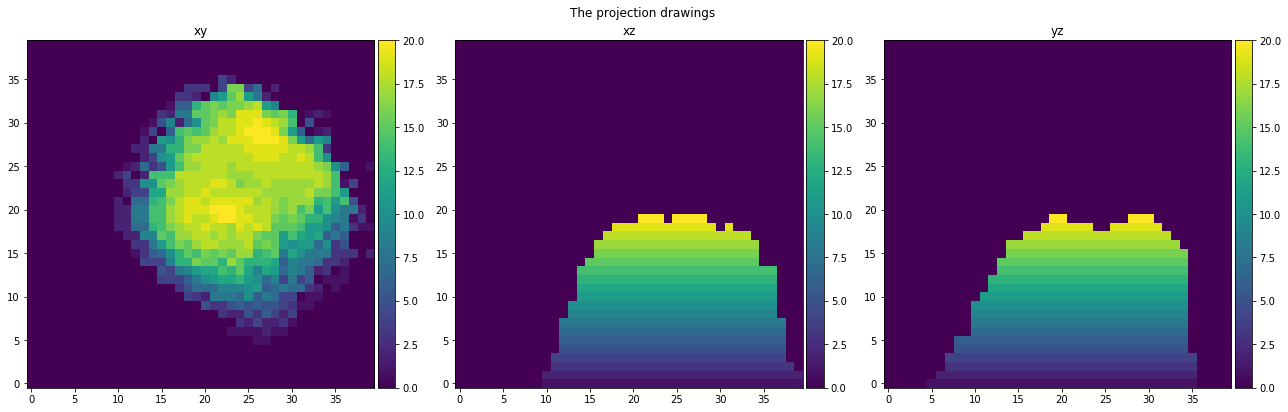

In [279]:
print(num_0)
print(num_1)
print(num_1/num_0)
reflect_calculate(image,'054.png')